In [1]:
import xarray
import pandas

In [2]:
import utils.compound as compound
import utils.timePeriod as tp
from helpers.fileHandler import to_365day_monthly 
%run helpers/impactPlots.ipynb

# Load the datasets

Xarray doesn't load direct from CSV but Pandas does:

In [3]:
iodPd=pandas.read_csv('ref/abram2020/abram2020-iod-event.txt', sep='	', header=135, index_col=0)
iodPd

,July-Dec-anom,30-y-stdev,pIOD-events,epIOD-events,Unnamed: 5
Year,,,,,
1240,NaN,5.110536,0.0,0.0,NaN
1241,-0.605520,10.436320,0.0,0.0,NaN
1242,-0.143572,8.061502,0.0,0.0,NaN
1243,0.573652,4.840072,0.0,0.0,NaN
1244,0.497826,2.580668,0.0,0.0,NaN
...,...,...,...,...,...
2015,1.534088,24.583960,1.0,0.0,NaN
2016,-1.668266,27.976240,0.0,0.0,NaN
2017,0.620306,28.902430,0.0,0.0,NaN


As I don't know how to use pandas, im just going to turn that into an xr

In [4]:
iodXr=iodPd.to_xarray()

iodXr=iodXr.rename({'Year ':'year'})

In [5]:
indexXr=xarray.Dataset()

indexXr['dmi']=iodXr['July-Dec-anom'].sel(year=range(1900,2006))

indexXr

<xarray.Dataset>
Dimensions:  (year: 106)
Coordinates:
  * year     (year) int64 1900 1901 1902 1903 1904 ... 2001 2002 2003 2004 2005
Data variables:
    dmi      (year) float64 -1.003 -1.043 0.6172 ... 0.5767 0.234 -0.9248

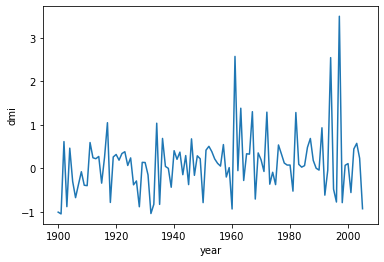

In [6]:
indexXr.dmi.plot()

In [7]:
samPd=pandas.read_csv('ref/fogt/recons_mean7100.txt', index_col=0, sep=' +', na_values=-999.900)

samPd

<ipython-input-7-255e97c9cb03>:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  samPd=pandas.read_csv('ref/fogt/recons_mean7100.txt', index_col=0, sep=' +', na_values=-999.900)


,DJF,MAM,JJA,SON
1865,0.088,-1.740,NaN,NaN
1866,0.937,0.726,NaN,NaN
1867,-2.675,1.564,NaN,NaN
1868,-1.724,-0.246,NaN,NaN
1869,-2.429,-0.649,NaN,NaN
...,...,...,...,...
2001,1.015,1.686,1.583,1.485
2002,1.657,-0.943,-1.933,-3.352
2003,0.139,2.644,1.767,-0.555
2004,-0.488,1.072,0.018,-0.047


In [8]:
samXr=samPd.to_xarray()

In [9]:
samXr=samXr.rename({'index':'year'}).sel(year=range(1900,2006))

In [10]:
samXr

<xarray.Dataset>
Dimensions:  (year: 106)
Coordinates:
  * year     (year) int64 1900 1901 1902 1903 1904 ... 2001 2002 2003 2004 2005
Data variables:
    DJF      (year) float64 0.119 -2.468 -2.457 -0.444 ... 0.139 -0.488 nan
    MAM      (year) float64 -0.46 -1.014 -1.835 -1.464 ... 2.644 1.072 0.983
    JJA      (year) float64 nan nan nan nan nan ... -1.933 1.767 0.018 -0.047
    SON      (year) float64 nan nan nan nan nan ... -3.352 -0.555 -0.047 -0.848

In [11]:
#going spring/summer average is close to my october to march averaging (but not exactly)

indexXr['samSummer']=samXr[['SON','DJF']].to_array().mean('variable')
indexXr['samWinter']=samXr[['MAM','JJA']].to_array().mean('variable')

In [12]:
indexXr

<xarray.Dataset>
Dimensions:    (year: 106)
Coordinates:
  * year       (year) int64 1900 1901 1902 1903 1904 ... 2002 2003 2004 2005
Data variables:
    dmi        (year) float64 -1.003 -1.043 0.6172 ... 0.5767 0.234 -0.9248
    samSummer  (year) float64 0.119 -2.468 -2.457 ... -0.208 -0.2675 -0.848
    samWinter  (year) float64 -0.46 -1.014 -1.835 -1.464 ... 2.205 0.545 0.468

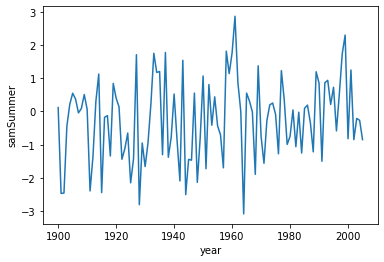

In [13]:
indexXr.samSummer.plot()

In [14]:
ensoPd=pandas.read_csv('ref/freund2019Enso/freund2019enso.txt',sep='	', header=105, index_col=0)
ensoPd

,Season,NCT,NWP
age_CE,,,
1617,3,0.150,0.035
1617,6,-0.344,-0.081
1617,9,-0.300,-0.071
1617,12,-0.182,-0.043
1618,3,-0.098,-0.023
...,...,...,...
2007,3,0.101,0.001
2007,6,0.200,0.013
2007,9,0.134,0.004


In [15]:
ensoXr=ensoPd.to_xarray()

ensoXr=ensoXr.rename({'age_CE':'year'})

In [16]:
# winter-spring-summer average
ensoReducedXr=(
    ensoXr.where(ensoXr.Season==6, drop=True)
    +ensoXr.where(ensoXr.Season==9, drop=True)
    +ensoXr.where(ensoXr.Season==12, drop=True)
)/3

In [17]:
ensoReducedXr=ensoReducedXr.drop('Season').sel(year=range(1900,2006))

In [18]:
ensoReducedXr

<xarray.Dataset>
Dimensions:  (year: 106)
Coordinates:
  * year     (year) int64 1900 1901 1902 1903 1904 ... 2001 2002 2003 2004 2005
Data variables:
    NCT      (year) float64 -0.2337 -0.3247 0.6963 ... 0.06 0.09933 -0.2323
    NWP      (year) float64 0.106 0.03567 0.259 ... 0.04833 0.003667 -0.049

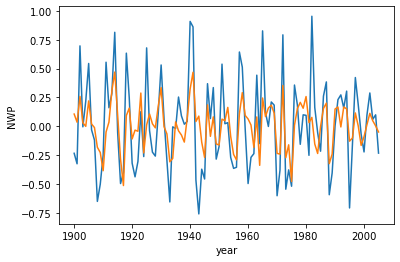

In [19]:
ensoReducedXr.NCT.plot()
ensoReducedXr.NWP.plot()

In [20]:
indexXr=xarray.merge([
    indexXr,
    ensoReducedXr
])

In [21]:
indexXr

<xarray.Dataset>
Dimensions:    (year: 106)
Coordinates:
  * year       (year) int64 1900 1901 1902 1903 1904 ... 2002 2003 2004 2005
Data variables:
    dmi        (year) float64 -1.003 -1.043 0.6172 ... 0.5767 0.234 -0.9248
    samSummer  (year) float64 0.119 -2.468 -2.457 ... -0.208 -0.2675 -0.848
    samWinter  (year) float64 -0.46 -1.014 -1.835 -1.464 ... 2.205 0.545 0.468
    NCT        (year) float64 -0.2337 -0.3247 0.6963 ... 0.06 0.09933 -0.2323
    NWP        (year) float64 0.106 0.03567 0.259 ... 0.04833 0.003667 -0.049

# Now, set some criteria to determine events

Per normal, 1 sigma for enso/iod. 0.5 sigma for SAM.

However, we don't have a good baseline period. Lets choose 1900-1930 (somewhat arbitrary?)

In [22]:
stdXr=indexXr.std()

In [23]:
criteriaXr=stdXr
criteriaXr['samWinter']=stdXr.samWinter/2
criteriaXr['samSummer']=stdXr.samSummer/2


In [24]:
criteriaXr

<xarray.Dataset>
Dimensions:    ()
Data variables:
    dmi        float64 0.7157
    samSummer  float64 0.6151
    samWinter  float64 0.4967
    NCT        float64 0.3929
    NWP        float64 0.1923

In [25]:
firePosXr, fireNegXr = compound.applyCriteria(indexXr, criteriaXr)

firePos: 
['samWinter', 'NWP', 'NCT', 'dmi']
fireNeg: 
['samSummer']


In [26]:
firePosXr

<xarray.Dataset>
Dimensions:    (year: 106)
Coordinates:
  * year       (year) int64 1900 1901 1902 1903 1904 ... 2002 2003 2004 2005
Data variables:
    samWinter  (year) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 1.0 0.0 1.0 1.0 0.0
    NWP        (year) float64 0.0 0.0 1.0 0.0 0.0 1.0 ... 0.0 0.0 0.0 0.0 0.0
    NCT        (year) float64 0.0 0.0 1.0 0.0 0.0 1.0 ... 0.0 0.0 0.0 0.0 0.0
    dmi        (year) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    samSummer  (year) float64 0.0 1.0 1.0 0.0 0.0 0.0 ... 0.0 1.0 0.0 0.0 1.0

In [27]:
firePosXr['ecCombined']=firePosXr[['NCT','NWP']].to_array().any('variable')
fireNegXr['ecCombined']=fireNegXr[['NCT','NWP']].to_array().any('variable')

In [28]:
eventsXr=xarray.concat(
    [
        firePosXr,
        fireNegXr
    ],
    'fire')

eventsXr['fire']=['pos','neg']

In [29]:
eventsXr.to_netcdf('results/reconstructEvents.nc')

In [30]:
eventsXr

<xarray.Dataset>
Dimensions:     (fire: 2, year: 106)
Coordinates:
  * year        (year) int64 1900 1901 1902 1903 1904 ... 2002 2003 2004 2005
  * fire        (fire) <U3 'pos' 'neg'
Data variables:
    samWinter   (fire, year) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 1.0 0.0 0.0 0.0
    NWP         (fire, year) float64 0.0 0.0 1.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    NCT         (fire, year) float64 0.0 0.0 1.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    dmi         (fire, year) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 1.0
    samSummer   (fire, year) float64 0.0 1.0 1.0 0.0 0.0 ... 1.0 0.0 0.0 0.0 0.0
    ecCombined  (fire, year) bool False False True False ... False False False

In [31]:
#event years

for iEvent in eventsXr.data_vars:

    years=eventsXr.where(
        eventsXr[iEvent].sel(fire='pos')==True, 
        drop=True
    ).year.values
    
    print(str(iEvent) + ' : ' + str(years))

samWinter : [1911 1919 1925 1930 1931 1934 1938 1940 1942 1950 1960 1961 1967 1976
 1979 1982 1985 1989 1993 1997 1998 1999 2000 2001 2003 2004]
NWP : [1902 1905 1913 1914 1923 1930 1940 1941 1958 1965 1972 1978 1980 1987]
NCT : [1902 1905 1911 1914 1918 1925 1930 1940 1941 1951 1957 1958 1963 1965
 1972 1982 1997]
dmi : [1917 1934 1961 1963 1967 1972 1982 1991 1994 1997]
samSummer : [1901 1902 1911 1912 1915 1918 1922 1923 1924 1925 1926 1928 1929 1930
 1931 1936 1938 1939 1941 1942 1944 1945 1946 1948 1949 1951 1956 1957
 1964 1968 1970 1971 1976 1979 1980 1982 1984 1988 1991 2000 2002 2005]
ecCombined : [1902 1905 1911 1913 1914 1918 1923 1925 1930 1940 1941 1951 1957 1958
 1963 1965 1972 1978 1980 1982 1987 1997]


SAM: Marshall and Fogt results are pretty similar (2 or 3 differences)

Cai et al. 2015, (starting 1979, using ORA-s4 SST, DJF averages) identifies El Nino as:
- CP: 1990, 2002, 2004, 2009
- EP: 1982, 1997
EP matches NCT well (good). CP does not match NWP, although Freund report poor skill metric after ~1985


Abram et al 2020 (observational):
- IOD: 1982, 1991, 1994, 1997, 2007, 2008, 2012, 2015, 2019 (good)


# If we plot some impact maps now, do they look plausible?

In [32]:
eventsXr=xarray.load_dataset('results/reconstructEvents.nc')

In [33]:
prTWarmSeasonXr = xarray.load_dataset('results/observPrTmaxAnoms.nc')

In [34]:
prTWarmSeasonXr

<xarray.Dataset>
Dimensions:       (lat: 691, lon: 886, year: 120)
Coordinates:
  * lat           (lat) float32 -44.5 -44.45 -44.4 -44.35 ... -10.1 -10.05 -10.0
  * lon           (lon) float32 112.0 112.1 112.1 112.2 ... 156.1 156.2 156.2
  * year          (year) int64 1900 1901 1902 1903 1904 ... 2016 2017 2018 2019
Data variables:
    tsAnomWinter  (year, lat, lon) float32 nan nan nan ... -0.03632 -0.03523
    tsAnomSummer  (year, lat, lon) float32 nan nan nan ... 0.04448 0.04579
    prAnomWinter  (year, lat, lon) float64 5.921e-16 0.0 ... 0.0004324 0.0004152
    prAnomSummer  (year, lat, lon) float64 0.0004444 0.000446 ... -0.06802
    prWinter      (lat, lon) float64 11.01 11.0 11.0 10.99 ... 5.803 5.816 5.827
    prSummer      (lat, lon) float64 2.243 2.243 2.243 ... 9.215 9.224 9.23
    tsWinter      (lat, lon) float32 11.12 11.13 11.13 ... 28.14 28.13 28.12
    tsSummer      (lat, lon) float32 8.469 8.476 8.482 ... 29.48 29.47 29.46

In [35]:
eventsLs = {
    'summer':['NCT', 'NWP', 'ecCombined','dmi','samSummer'],
    'winter':['NCT', 'NWP', 'ecCombined','dmi','samWinter']
}

# Anoms for indiv indices - Fire Pos

In [36]:
%run helpers/impactPlots.ipynb

pos
winter


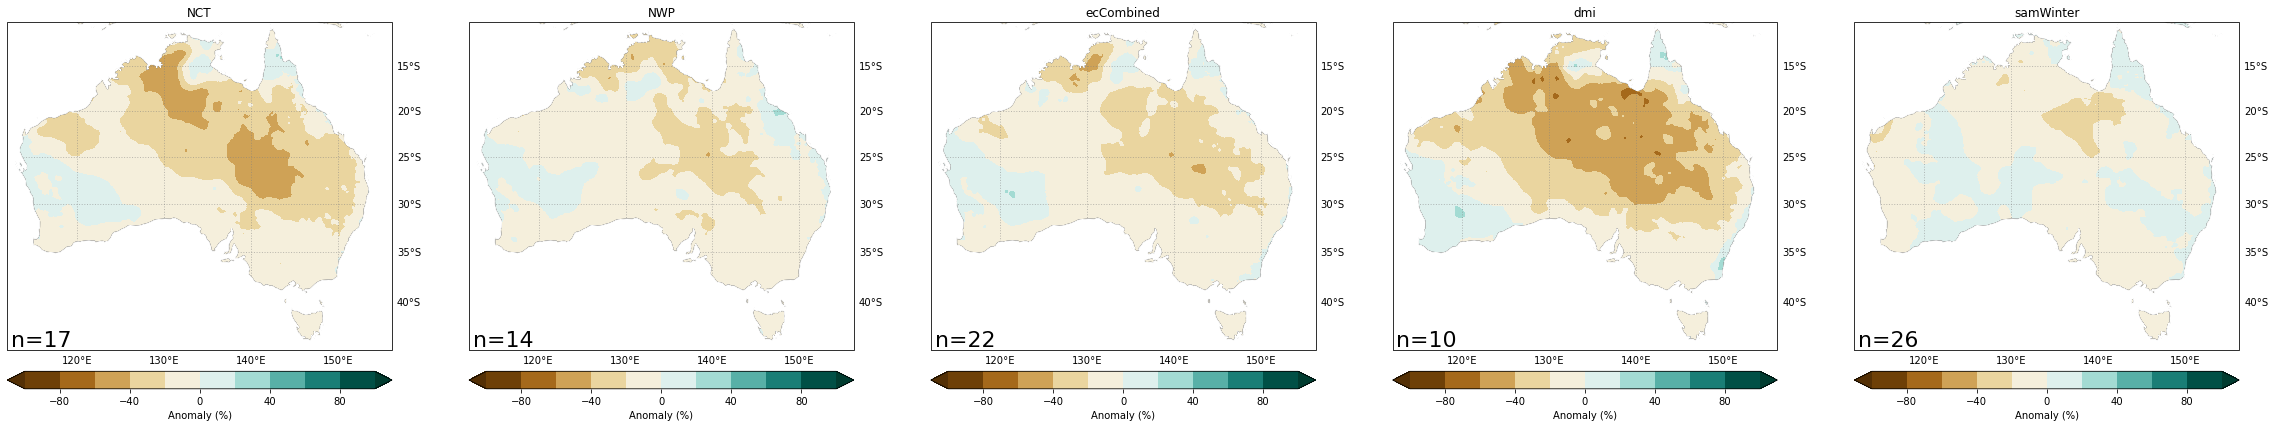

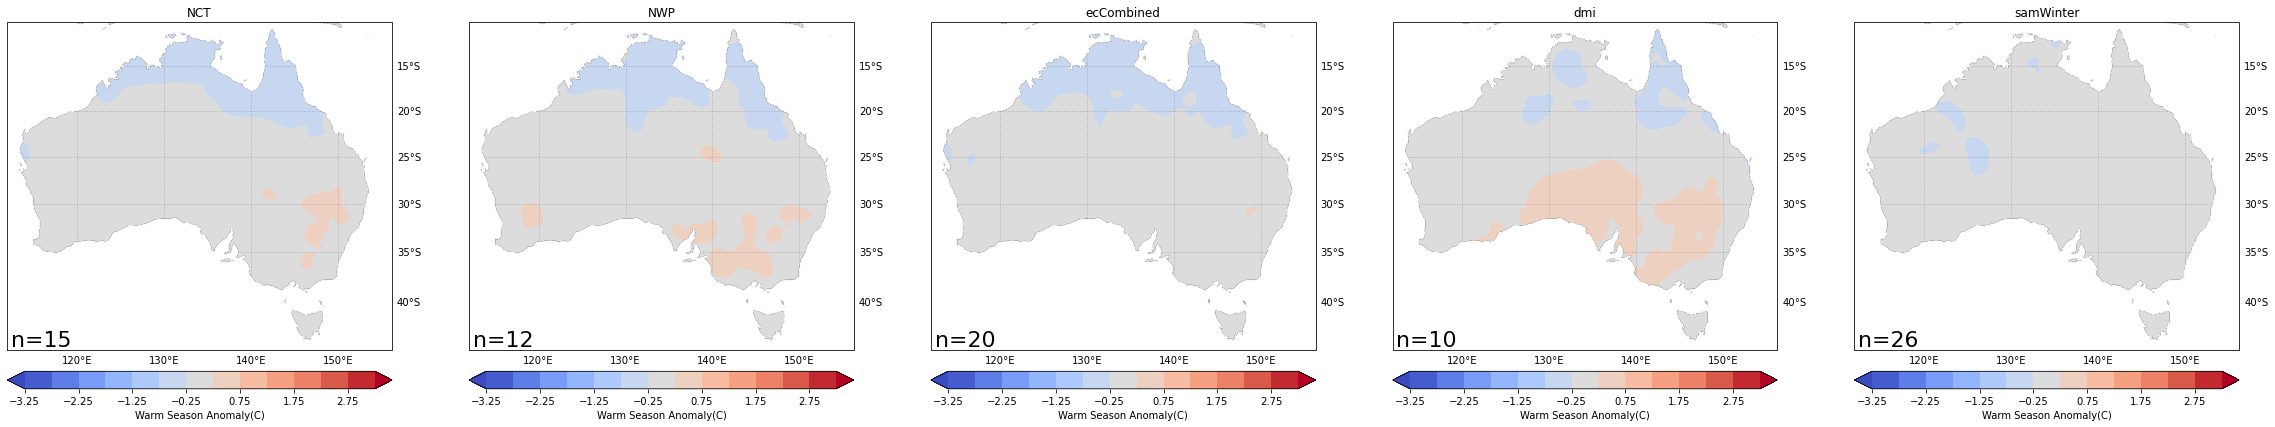

summer


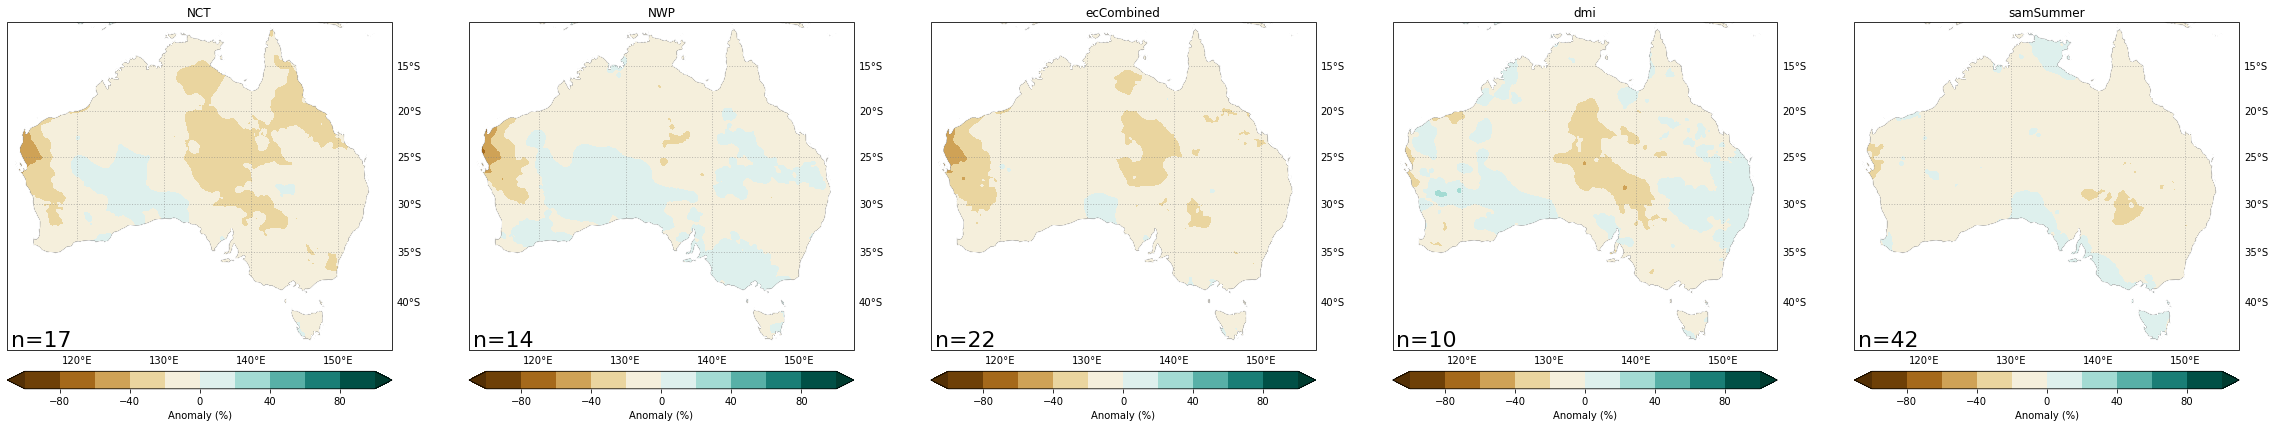

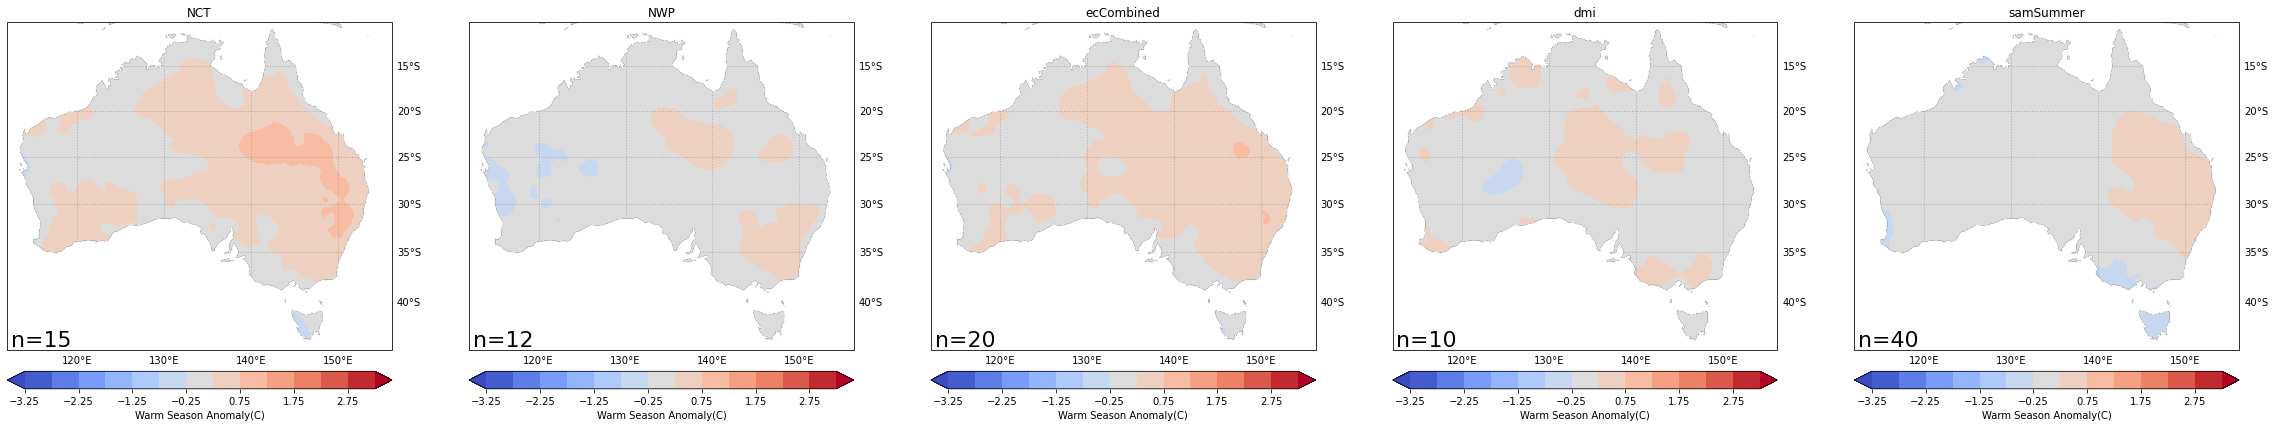

neg
winter


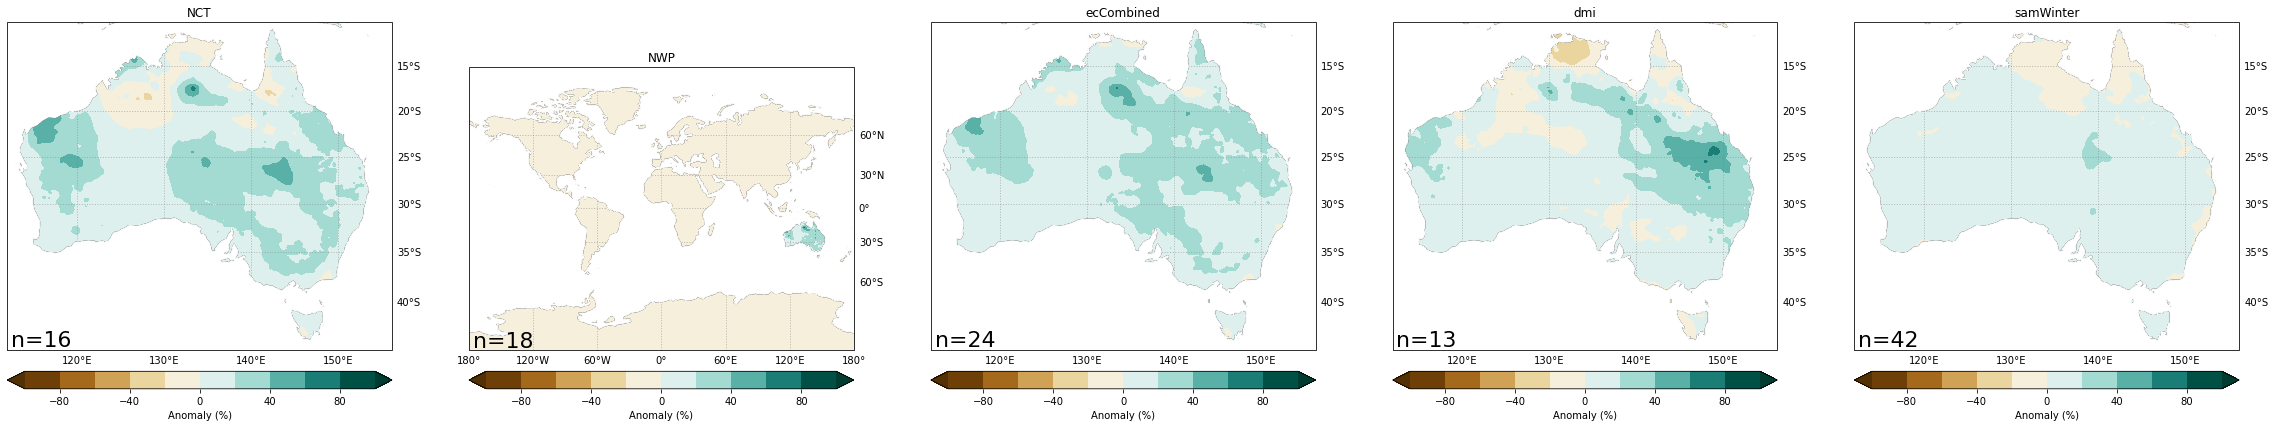

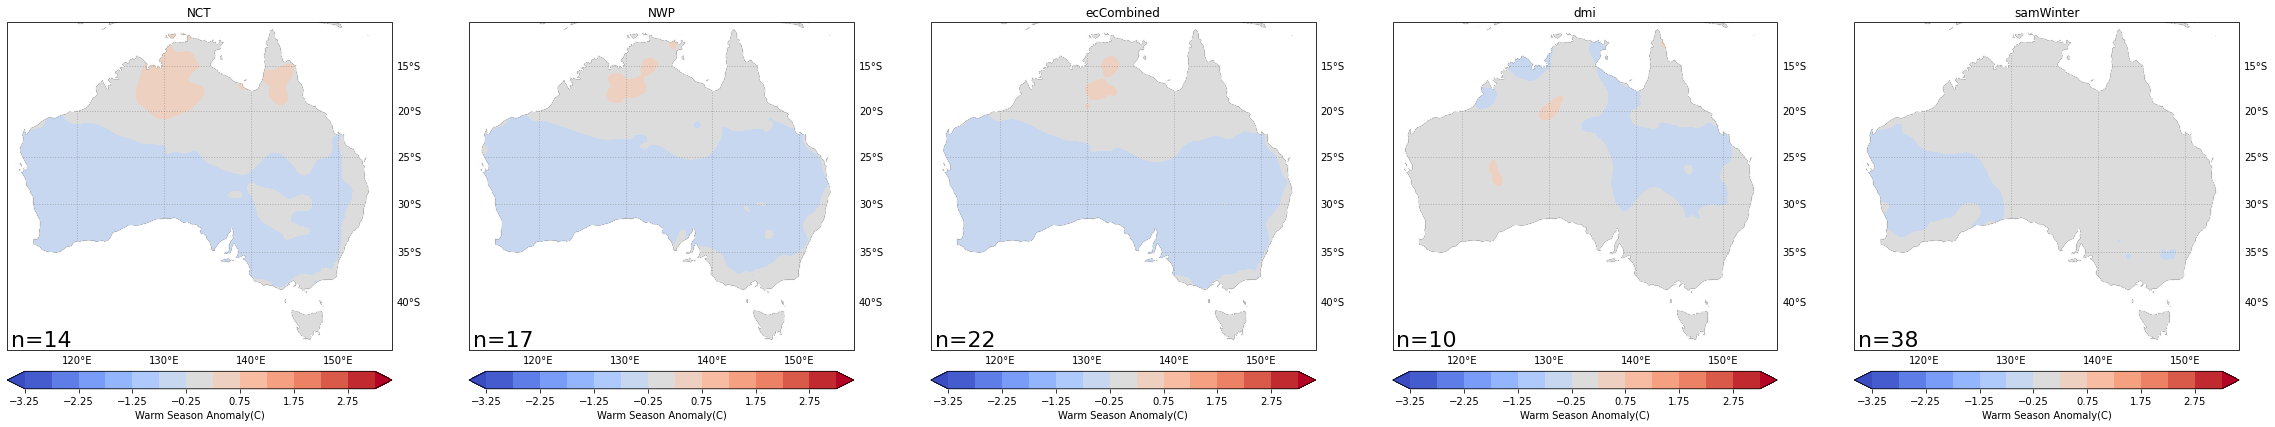

summer


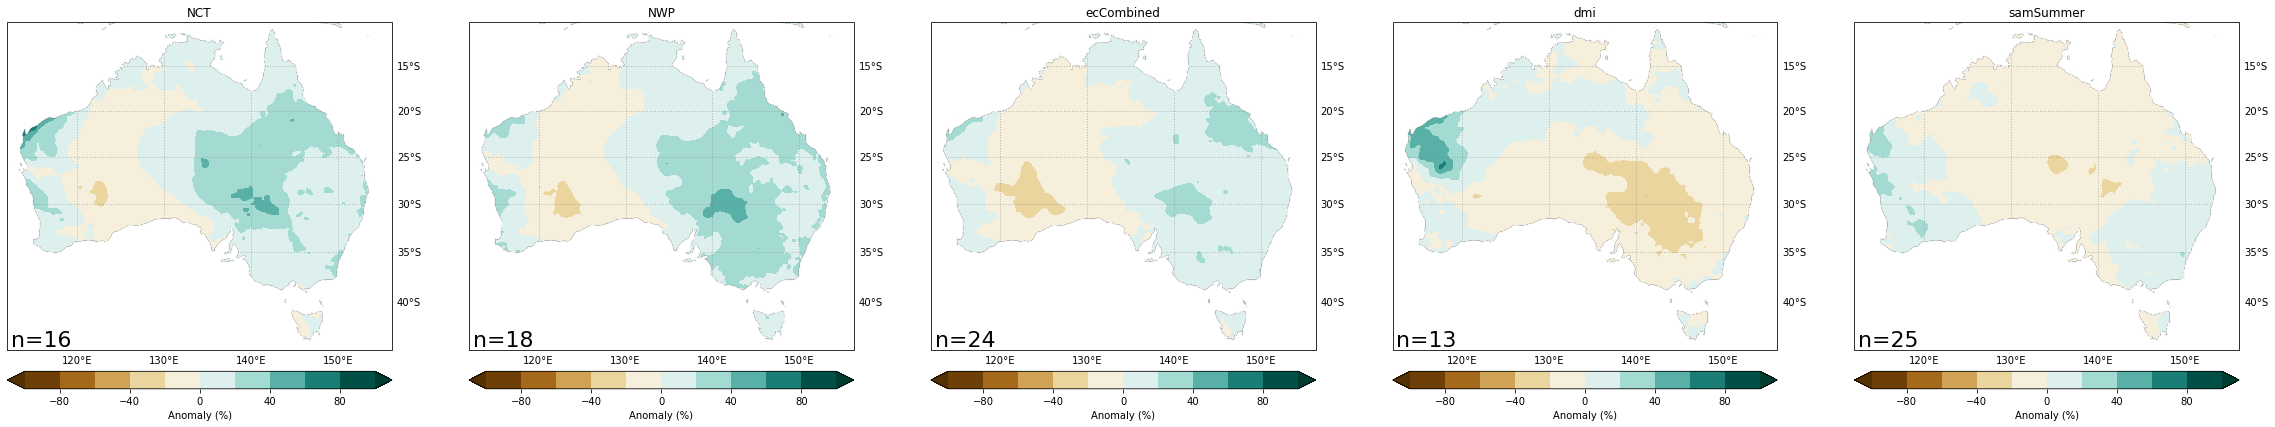

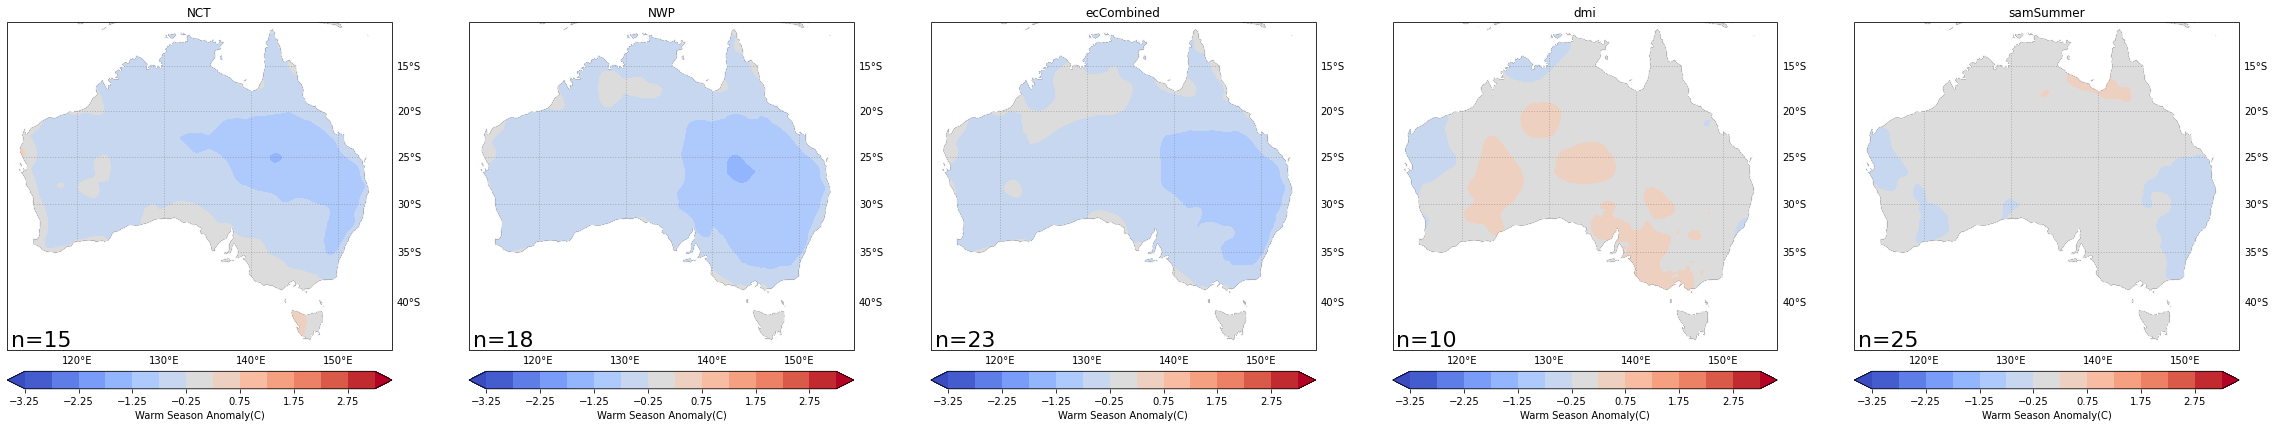

In [37]:
for iFire in ['pos','neg']:
    print(iFire)
    for iSeason in ['winter','summer']:
        print(iSeason)

        indexPlotter(
            (prTWarmSeasonXr['prAnom'+iSeason.capitalize()]*100/prTWarmSeasonXr['pr'+iSeason.capitalize()]).rename('prPercent'), 
            eventsXr.sel(fire=iFire, drop=True), 
            eventsLs[iSeason],
            showOcean=False
        )
        plt.show()
        indexPlotter(
            prTWarmSeasonXr['tsAnom'+iSeason.capitalize()], 
            eventsXr.sel(fire=iFire, drop=True), 
            eventsLs[iSeason],
            showOcean=False
        )
        plt.show()

NCT is cool tongue (EP)

NWP is warm pool (CP)

The result above might be skewed a bit by the correlation between NCT and NWP. So lets look at NWP (not NCT) only too:

In [38]:
nwpOnlyXr=xarray.merge([
    eventsXr.NWP,
    eventsXr.NCT==0
]).to_array().all('variable').to_dataset(name='nwpOnly')

In [39]:
nwpOnlyXr

<xarray.Dataset>
Dimensions:  (fire: 2, year: 106)
Coordinates:
  * year     (year) int64 1900 1901 1902 1903 1904 ... 2001 2002 2003 2004 2005
  * fire     (fire) object 'pos' 'neg'
Data variables:
    nwpOnly  (fire, year) bool False False False False ... False False False

In [40]:
indexPlotter(prTWarmSeasonXr.precAnom, nwpOnlyXr.sel(fire='pos'), ['nwpOnly'])
plt.show()

indexPlotter(prTWarmSeasonXr.tsAnom, nwpOnlyXr.sel(fire='pos'), ['nwpOnly'])

AttributeError: 'Dataset' object has no attribute 'precAnom'

# Anoms for indiv indices - Fire Neg

In [ ]:
indexPlotter(prTWarmSeasonXr.precAnom, eventsXr.sel(fire='neg'), eventsLs)
plt.show()

indexPlotter(prTWarmSeasonXr.tsAnom, eventsXr.sel(fire='neg'), eventsLs)

# Compound them and see what happens

In [ ]:
compoundEventsXr=compound.compound(eventsXr)

In [ ]:
indexSet='ecCombinedDmiSammarshall'

In [ ]:
compoundEventsXr[indexSet].to_dataset('compound')

In [ ]:
compoundEventsLs=[*compoundEventsXr.pairs, 'all3']

In [ ]:
compoundEventsXr[indexSet].sel(fire='pos', drop=True).to_dataset('compound')

In [ ]:
#enso+iod compound years, realWorld

for iCompound in compoundEventsLs:

    years=compoundEventsXr.where(
        compoundEventsXr[indexSet].sel(fire='pos', compound=iCompound)==True, 
        drop=True
    ).year.values
    
    print(str(iCompound) + ' : ' + str(years))

In [ ]:
indexPlotter(
    prTWarmSeasonXr.precAnom, 
    compoundEventsXr[indexSet].sel(fire='pos', drop=True).to_dataset('compound'), 
    compoundEventsLs
)
plt.show()

indexPlotter(
    prTWarmSeasonXr.tsAnom, 
    compoundEventsXr[indexSet].sel(fire='pos', drop=True).to_dataset('compound'), 
    compoundEventsLs
)

In [ ]:
indexPlotter(
    prTWarmSeasonXr.precAnom, 
    compoundEventsXr[indexSet].sel(fire='neg', drop=True).to_dataset('compound'), 
    compoundEventsLs
)
plt.show()

indexPlotter(
    prTWarmSeasonXr.tsAnom, 
    compoundEventsXr[indexSet].sel(fire='neg', drop=True).to_dataset('compound'), 
    compoundEventsLs
)

# And comparison between the three enso indices

In [ ]:
ensoIodEventsXr=compoundEventsXr.sel(compound='enso+iod', drop=True)

In [ ]:
ensoIodEventsLs=list(ensoIodEventsXr.data_vars)

In [ ]:
ensoIodEventsLs

In [ ]:
ensoIodEventsLs=[
    'ecCombinedDmiSamfogt',
    'NWPDmiSamfogt',
    'NCTDmiSamfogt'
]


In [ ]:
indexPlotter(
    prTWarmSeasonXr.precAnom, 
    ensoIodEventsXr.sel(fire='pos'), 
    ensoIodEventsLs
)
plt.show()

indexPlotter(
    prTWarmSeasonXr.tsAnom, 
    ensoIodEventsXr.sel(fire='pos'), 
    ensoIodEventsLs
)

n=0 for fire Neg Case